# 모델 훈련


## 모델1 사용할 특성

1. CryoSleep
2. HomePlanet
3. Age
4. AmenitiesFare_1
5. AmenitiesFare_2
6. Destination
7. deck
8. side

In [175]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [177]:
os.chdir(r"D:\hyoon\side_project\kaggle\spaceship_titanic\notebooks")
!pwd

/d/hyoon/side_project/kaggle/spaceship_titanic/notebooks


In [178]:
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')

분석을 위해 특성 추가

In [179]:
df_train["PassengerGroup"] = df_train['PassengerId'].apply(lambda x: x.split("_")[0])
df_train = pd.merge(df_train, pd.DataFrame(df_train[["PassengerGroup"]].value_counts(), columns=["GroupSize"]).reset_index(), on="PassengerGroup", how="left")

In [180]:
def add_v1_features(df):
    """모델 version 1에 사용할 특징을 추가한다.

    Args:
        df (pd.DataFrame): 사용할 데이터
        
    Returns:
        pd.DataFrame: 사용할 특징을 담은 데이터
    """
    v1_features = ["CryoSleep", "HomePlanet", "Age", "AmenitiesFare_1", "AmenitiesFare_2", "Destination", "Deck", "Side"]
    
    df_train["AmenitiesFare_1"] = df_train[["RoomService", "ShoppingMall"]].sum(axis=1).apply(lambda x: np.log(x) if x > 0 else 0)
    df_train["AmenitiesFare_2"] = df_train[["FoodCourt", "Spa", "VRDeck"]].sum(axis=1).apply(lambda x: np.log(x) if x > 0 else 0)
    
    df_train["Deck"] = df_train["Cabin"].str.split("/").str[0]
    df_train["Side"] = df_train["Cabin"].str.split("/").str[2]
    
    return df_train[v1_features]

In [181]:
feature_using = extract_v1_features(df_train)

In [182]:
print(f"train data_len: {df_train.shape[0]}")
print(f"test data_len: {df_test.shape[0]}")

train data_len: 8693
test data_len: 4277


# Feature engineering

## 이름 대체하기

뒷 부분은 성에 해당하므로 특별히 관련이 없을 것이라 생각,     
이름에 해당하는 앞부분만 사용한다.

In [183]:
df_train['Name'] = df_train.Name.str.extract('([A-Za-x]+) ')
df_test['Name'] = df_test.Name.str.extract('([A-Za-x]+) ')

In [184]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,GroupSize,AmenitiesFare_1,AmenitiesFare_2,Deck,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham,False,0001,1,0.000000,0.000000,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna,True,0002,1,4.897840,6.400257,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark,False,0003,2,3.761200,9.243775,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam,False,0003,2,5.916202,8.477412,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,NaN,True,0004,1,6.118097,6.456770,F,S


In [185]:
pd.crosstab(df_train['Name'], df_train['HomePlanet']).T#.style.background_gradient(cmap='summer_r')

Name,Aard,Aarjel,Aark,Aarone,Aars,Acceleb,Achah,Achbah,Achib,Achira,...,rmark,rmino,rmion,rohs,rona,ront,ros,s,sma,ton
HomePlanet,,,,,,,,,,,,,,,,,,,,,
Earth,0,0,0,7,0,0,0,0,0,0,...,0,0,0,0,8,4,0,0,0,3
Europa,0,0,0,0,0,2,2,3,4,4,...,1,2,2,0,0,0,0,0,0,0
Mars,1,2,2,0,1,0,0,0,0,0,...,0,0,0,1,0,0,2,8,3,0


In [186]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerGroup', 'GroupSize', 'AmenitiesFare_1',
       'AmenitiesFare_2', 'Deck', 'Side'],
      dtype='object')

# Null 값 채우기

## CryoSleep

1. CryoSleep == True 승객은 어메니티에 소비를 하지 않는다. 

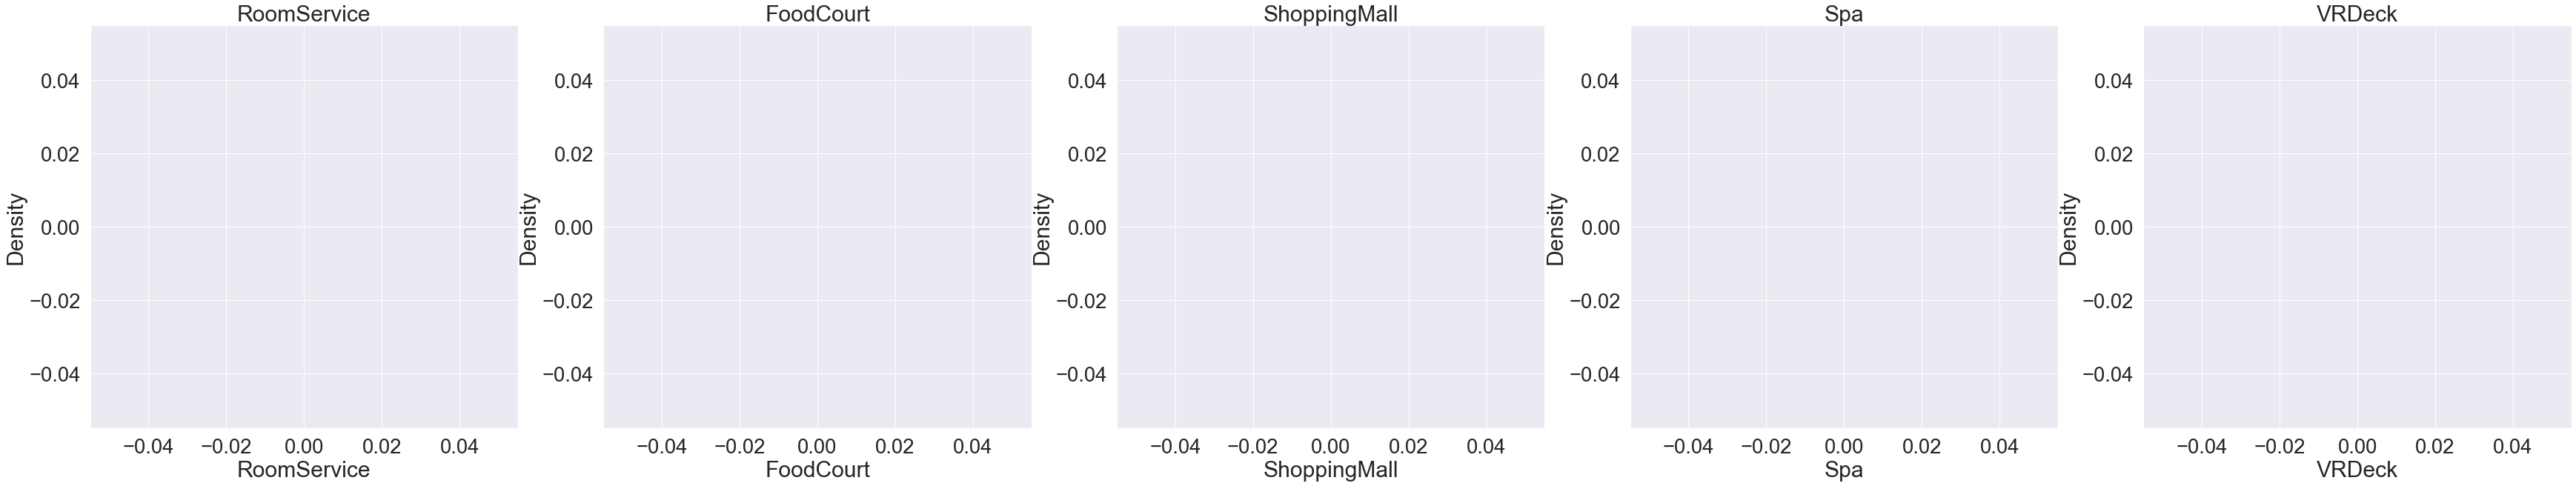

In [187]:
fig, ax = plt.subplots(1, 5, figsize=(60, 10))
for i, amen in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    g = sns.kdeplot(df_train[(df_train["CryoSleep"] == True)][amen].map(lambda x: np.log(x) if x > 0 else 0), ax=ax[i])
    g.set_title(amen)


In [188]:
list(df_train["Destination"].unique())[0]

'TRAPPIST-1e'

2. 목적지가 'TRAPPIST-1e'인 승객중 CryoSleep == False인 비율이 많다.

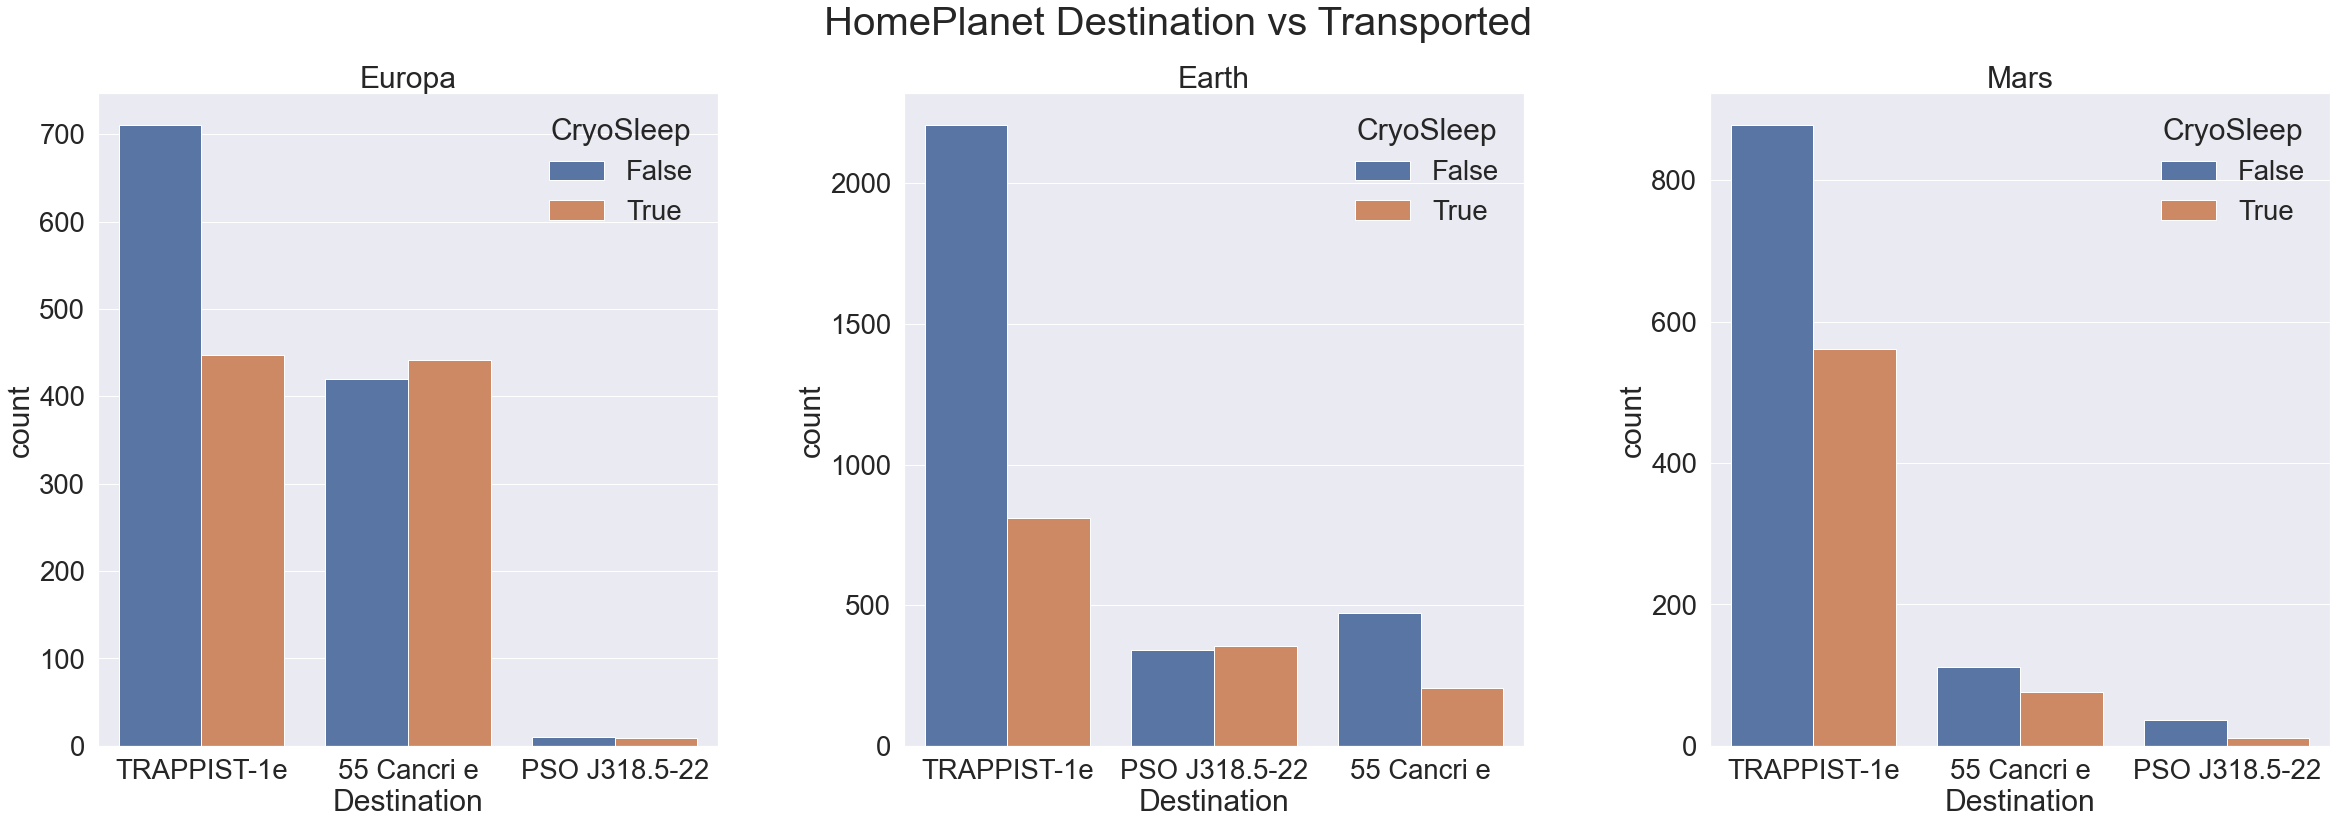

In [189]:
homeplanets = list(df_train["HomePlanet"].unique())[:-1]
destinations = list(df_train["Destination"].unique())[:-1]
f, ax = plt.subplots(1, 3, figsize=(40, 12))
for i, p in enumerate(homeplanets):
    y_position = 1.02
    g = sns.countplot("Destination", hue="CryoSleep", data=df_train[df_train["HomePlanet"]==p], ax=ax[i])
    g.set_title(p)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
f.suptitle("HomePlanet Destination vs Transported", fontsize=40)    
plt.show()

3. GroupSize == 1 또는 HomePlanet == 'Earth'인 승객 중 CryoSleep == False 인 승객의 비율이 높다.

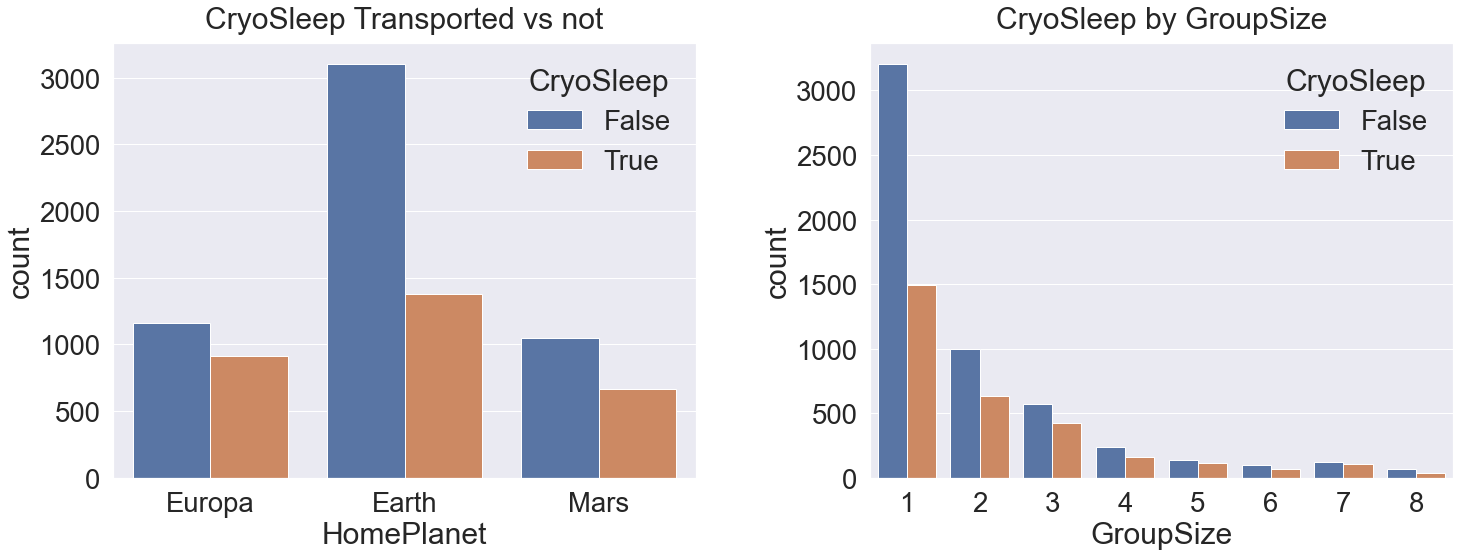

In [190]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot("HomePlanet", hue="CryoSleep", data=df_train, ax=ax[0])
ax[0].set_title("CryoSleep Transported vs not", y=y_position)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
sns.countplot("GroupSize", hue="CryoSleep", data=df_train, ax=ax[1])
ax[1].set_title("CryoSleep by GroupSize", y=y_position)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [191]:
feature_using["CryoSleep"].isnull().sum()

217

In [192]:
feature_using["CryoSleep"].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [193]:
def fill_cryosleep_null(x):
    
    if pd.isnull(x["CryoSleep"]):
        # 어메니티에 사용한 금액이 없는 경우
        if x[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum() == 0:
            return True
        # 목적지가 "TRAPPIST-1e" 인 경우
        elif x["Destination"] == "TRAPPIST-1e":
            return False
        # 혼자 여행 or 출신지가 Earth인 경우
        elif x["GroupSize"] == 1 or x["HomePlanet"] == "Earth":
            return False
        else:
            return True
    else:
        return x["CryoSleep"]


In [194]:
test = df_train.apply(fill_cryosleep_null, axis=1)

## HomePlanet

In [195]:
df_train["HomePlanet"].isnull().sum()

201

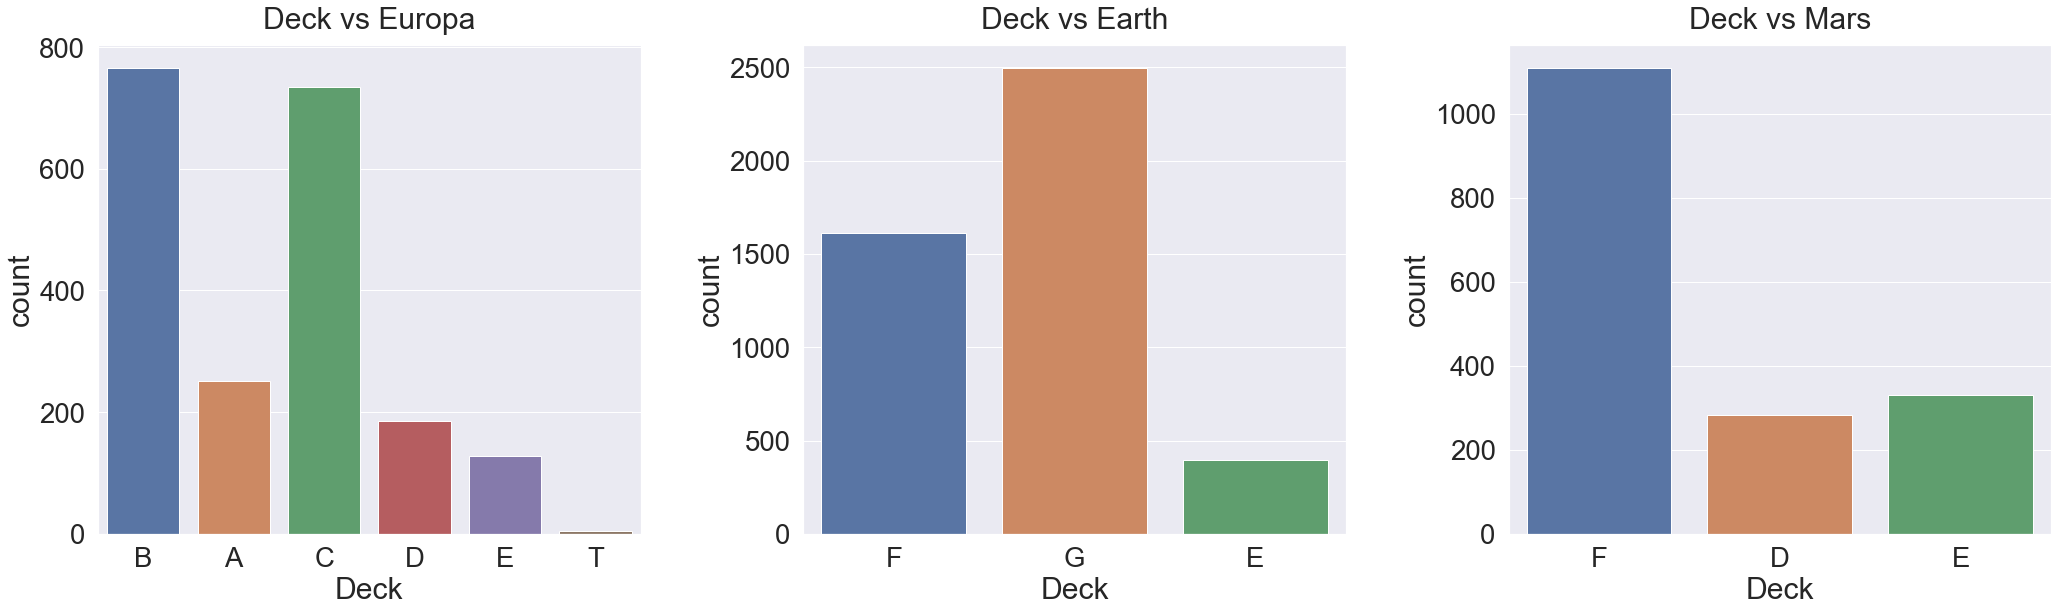

In [196]:
y_position = 1.02
f, ax = plt.subplots(1, 3, figsize=(35, 9))

for i, p in enumerate(list(df_train["HomePlanet"].unique()[:-1])):
    sns.countplot("Deck", data=df_train[df_train["HomePlanet"] == p], ax=ax[i])
    ax[i].set_title(f"Deck vs {p}", y=y_position)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [198]:
count_mars = df_train[(df_train["HomePlanet"] == "Mars")]["Deck"].count()
count_earth = df_train[(df_train["HomePlanet"] == "Earth")]["Deck"].count()
weight =  count_mars / (count_mars + count_earth)

f_earth = df_train[(df_train["Deck"] == 'F') & (df_train["HomePlanet"] == "Earth")]["Deck"].count() / df_train[df_train["Deck"] == 'F']['Deck'].count() * weight
f_mars = df_train[(df_train["Deck"] == 'F') & (df_train["HomePlanet"] == "Mars")]["Deck"].count() / df_train[df_train["Deck"] == 'F']['Deck'].count() * (1 - weight)
print(f"F percentage for Earth : {f_earth}")
print(f"F percentage for Mars : {f_mars}")

F percentage for Earth : 0.15969523023270857
F percentage for Mars : 0.28745231077350464


In [199]:
count_mars = df_train[(df_train["HomePlanet"] == "Mars")]["Deck"].count()
count_europa = df_train[(df_train["HomePlanet"] == "Europa")]["Deck"].count()
weight =  count_mars / (count_mars + count_europa)

d_europa = df_train[(df_train["Deck"] == 'D') & (df_train["HomePlanet"] == "Europa")]["Deck"].count() / df_train[(df_train["Deck"] == "D")]["Deck"].count() * weight
d_mars = df_train[(df_train["Deck"] == 'D') & (df_train["HomePlanet"] == "Mars")]["Deck"].count() / df_train[(df_train["Deck"] == "D")]["Deck"].count() * (1 - weight)
print(f"D percentage for Europa : {d_europa}")
print(f"D percentage for Mars : {d_mars}")

D percentage for Europa : 0.17670541814522536
D percentage for Mars : 0.3220499443885388


vs Deck
1. deck == G => Earth
2. deck == F, D => Mars
3. deck in ["A", "B", "C", "E", "T"] => Europa

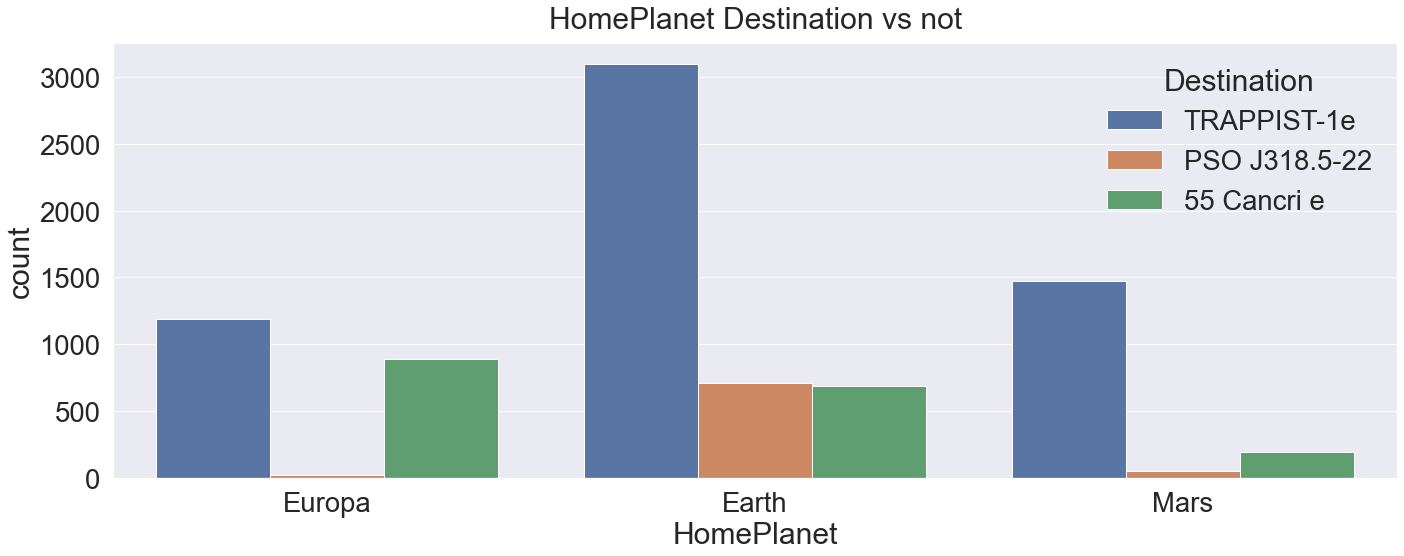

In [202]:
y_position = 1.02
f, ax = plt.subplots(1, 1, figsize=(23, 8))
sns.countplot("HomePlanet", hue="Destination", data=df_train, ax=ax)
ax.set_title("HomePlanet Destination vs not", y=y_position)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [206]:
df_train["Destination"].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [212]:
count_earth = df_train[(df_train["HomePlanet"] == "Earth")]["Deck"].count()
count_europa = df_train[(df_train["HomePlanet"] == "Europa")]["Deck"].count()
weight =  count_earth / (count_earth + count_europa)

d_europa = df_train[(df_train["Destination"] == '55 Cancri e') & (df_train["HomePlanet"] == "Europa")]["Destination"].count() / df_train[(df_train["Destination"] == "55 Cancri e")]["Destination"].count() * weight
d_earth = df_train[(df_train["Destination"] == '55 Cancri e') & (df_train["HomePlanet"] == "Mars")]["Destination"].count() / df_train[(df_train["Destination"] == "55 Cancri e")]["Destination"].count() * (1 - weight)
print(f"55 Cancri e percentage for earth : {d_earth}")
print(f"55 Cancri e percentage for Europa : {d_europa}")

55 Cancri e percentage for earth : 0.03374638893112361
55 Cancri e percentage for Europa : 0.3373035663000693


1. destination == '55 Cancri e' => Europa    
2. destination == 'PSO ... => Earth

### fill homeplanet null

1. deck == F, D => Mars
2. deck in ["A", "B", "C", "E", "T"] => Europa
3. destination == '55 Cancri e' => Europa

4. VIP == True => ~ Earth
5. GroupSize == 1 => Earth
6. CryoSleep == False => Earth
7. destination == 'PSO ... => Earth
8. deck == G => Earth

In [240]:
df_train_test = df_train.copy()

In [248]:
df_train_test['HomePlanet'].isnull().sum()

59

In [242]:
df_train_test.loc[(df_train_test['HomePlanet'].isnull()) & df_train_test['Deck'].isin(['F', 'D']), 'HomePlanet'] = 'Mars'

In [245]:
df_train_test.loc[(df_train_test['HomePlanet'].isnull()) & (df_train_test['Deck']).isin(["A", "B", "C", "E", "T"]), 'HomePlanet'] = "Europa"

In [247]:
df_train_test.loc[(df_train_test['HomePlanet'].isnull()) & (df_train_test['Destination'] == '55 Cancri e'), 'HomePlanet'] = "Europa"

In [264]:
def fill_homeplanet_null(x):
    if pd.isnull(x["HomePlanet"]):
        # Deck == "F" or "D"
        if x["Deck"] in ['F', 'D']:
            return "Mars"
        # Deck in 
        elif x["Deck"] in ["A", "B", "C", "D", "E", "T"] or x['Destination'] == '55 Cancri e':
            return "Europa"
        else:
            return 'Earth'
    else:
        return x["HomePlanet"]

In [262]:
train_df_test = df_train.copy()
train_df_test["HomePlanet"].isnull().sum()

201

In [263]:
train_df_test["HomePlanet"] = train_df_test.apply(fill_homeplanet_null, axis=1)
train_df_test["HomePlanet"].isnull().sum()

59

In [265]:
train_df_test["HomePlanet"] = train_df_test.apply(fill_homeplanet_null, axis=1)
train_df_test["HomePlanet"].isnull().sum()

0

## Destination

목적지가 PSO인 승객의 대부분은 Earth 출신이다.